In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from tqdm.auto import tqdm
from xgboost import XGBClassifier

from automated_scoring.config import cfg
from automated_scoring.io import load_dataset, save_dataset
from automated_scoring.features import DataFrameFeatureExtractor
from automated_scoring.classification.predict import predict_dataset, k_fold_predict
from automated_scoring.classification.optimize import optimize_smoothing, optimize_decision_thresholds
from automated_scoring.classification.visualization import (
    plot_confusion_matrix,
    plot_classification_timeline,
)

from scipy.signal import medfilt

cfg.key_keypoints = "keypoints"
cfg.key_timestamp = "timestamps"

cfg.trajectory_keys = (
    "keypoints",
    "timestamps",
)

In [2]:
%config InlineBackend.figure_format='retina'

In [3]:
dataset_train = load_dataset("mice_train", directory="datasets", target="dyads")
dataset_test = load_dataset("mice_test", directory="datasets", target="dyads")

Loading categories (attack, investigation, mount, none) from observations file, specify categories argument if incomplete.
Loading categories (attack, investigation, mount, none) from observations file, specify categories argument if incomplete.


In [4]:
extractor = DataFrameFeatureExtractor(cache_directory="feature_cache_mice").read_yaml("config_file.yaml")

In [5]:
len(extractor.feature_names)

201

In [6]:
def subsample_train(
    dataset,
    extractor,
    random_state=None,
    exclude=None,
):
    X_subsample_even, y_subsample_even = dataset.subsample(
        extractor,
        0.1,
        categories=("none", "investigation"),
        random_state=random_state,
        show_progress=False,
        exclude=exclude,
    )
    X_subsample_all, y_subsample_all = dataset.subsample(
        extractor,
        1.0,
        try_even_subsampling=False,
        categories=("attack", "mount"),
        random_state=random_state,
        show_progress=False,
        exclude=exclude,
    )
    return (
        pd.concat([X_subsample_even, X_subsample_all]),
        np.concatenate([y_subsample_even, y_subsample_all]),
    )

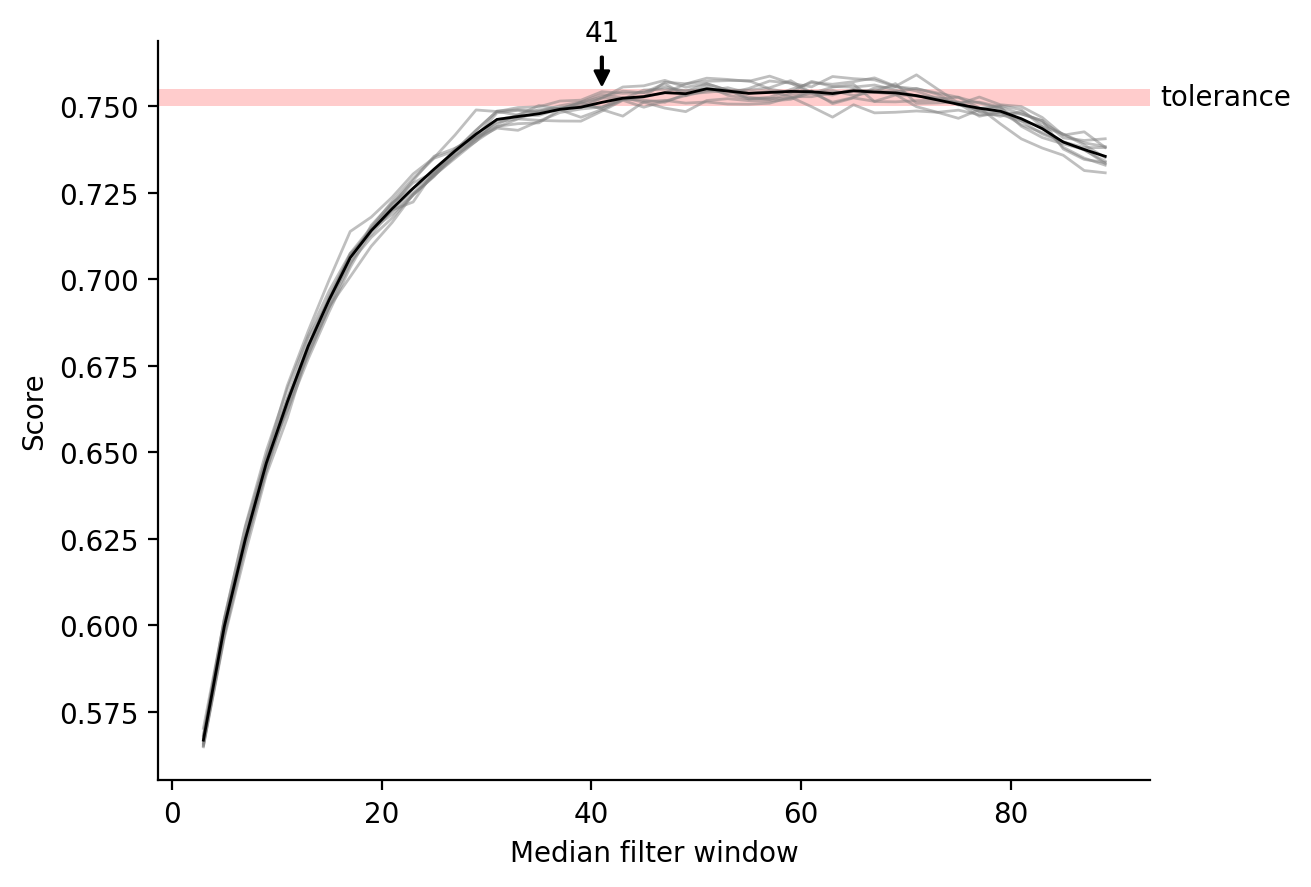

{'median_filter_window': 41.0}

In [7]:
best_parameters = optimize_smoothing(
    dataset_train,
    extractor,
    XGBClassifier,
    lambda probabilities, parameters: medfilt(probabilities, parameters["median_filter_window"]),
    smoothing_parameters_grid={"median_filter_window": np.arange(3, 91, 2)},
    num_iterations=10,
    # show_progress=True,
    k=5,
    exclude=[("intruder", "resident")],
    sampling_func=subsample_train,
    # show_k_fold_progress=True,
    tolerance=0.005,
)

best_parameters

In [ ]:
best_thresholds = optimize_decision_thresholds(
    dataset_train,
    extractor,
    XGBClassifier,
    smoothing_func=lambda probabilities: medfilt(probabilities, int(best_parameters["median_filter_window"])),
    num_iterations=10,
    # show_progress=True,
    k=5,
    exclude=[("intruder", "resident")],
    sampling_func=subsample_train,
    # show_k_fold_progress=True,
    decision_threshold_range=(0.0, 1.0),
    decision_threshold_step=0.01,
    tolerance=0.005,
    plot_results=True,
)

best_thresholds

In [10]:
# k_fold_results = []

# for _ in range(1):
#     for fold_train, fold_holdout in tqdm(dataset_train.k_fold(5, exclude=[("intruder", "resident")]), total=5):
#         X_train, y_train = subsample_train(fold_train)

#         xgbc = XGBClassifier().fit(
#             X_train.to_numpy(),
#             dataset_train.encode(y_train),
#             sample_weight=compute_sample_weight("balanced", dataset_train.encode(y_train)),
#         )

#         k_fold_results.append(
#             classify_dataset(
#                 xgbc,
#                 fold_holdout,
#                 extractor,
#                 pipeline=KNNImputer(),
#             )
#         )

  0%|          | 0/5 [00:00<?, ?it/s]

In [11]:
# category_labels = ['att', 'inv', 'mnt', 'none']

In [ ]:
# for k_fold_result in k_fold_results:

#     fig, axes = plt.subplots(2, 3, figsize=(12, 7), gridspec_kw={"hspace": 0.35, "wspace": 0.35})

#     plot_confusion_matrix(
#         k_fold_result.y_true_numeric,
#         k_fold_result.y_pred_numeric,
#         ax=axes[0, 0],
#         category_labels=category_labels,
#     )

#     plot_confusion_matrix(
#         dataset_train.encode(k_fold_result.annotations["category"].to_numpy()),
#         dataset_train.encode(k_fold_result.annotations["predicted_category"].to_numpy()),
#         ax=axes[0, 1],
#         category_labels=category_labels,
#     )

#     plot_confusion_matrix(
#         dataset_train.encode(k_fold_result.predictions["true_category"].to_numpy()),
#         dataset_train.encode(k_fold_result.predictions["category"].to_numpy()),
#         ax=axes[0, 2],
#         category_labels=category_labels,
#     )

#     axes[0, 0].set_title("Per frame")
#     axes[0, 1].set_title("Per annotation")
#     axes[0, 2].set_title("Per prediction")

#     k_fold_result.smooth([lambda arr: medfilt(arr, 39)])

#     plot_confusion_matrix(
#         k_fold_result.y_true_numeric,
#         k_fold_result.y_pred_numeric_smoothed,
#         ax=axes[1, 0],
#         category_labels=category_labels,
#     )

#     plot_confusion_matrix(
#         dataset_train.encode(k_fold_result.annotations["category"].to_numpy()),
#         dataset_train.encode(k_fold_result.annotations["predicted_category"].to_numpy()),
#         ax=axes[1, 1],
#         category_labels=category_labels,
#     )

#     plot_confusion_matrix(
#         dataset_train.encode(k_fold_result.predictions["true_category"].to_numpy()),
#         dataset_train.encode(k_fold_result.predictions["category"].to_numpy()),
#         ax=axes[1, 2],
#         category_labels=category_labels,
#     )

#     axes[1, 0].set_title("smoothed")
#     axes[1, 1].set_title("smoothed")
#     axes[1, 2].set_title("smoothed")

#     plt.show()
#     # break

In [75]:
# 16 seems systematically shifted, maybe 41,

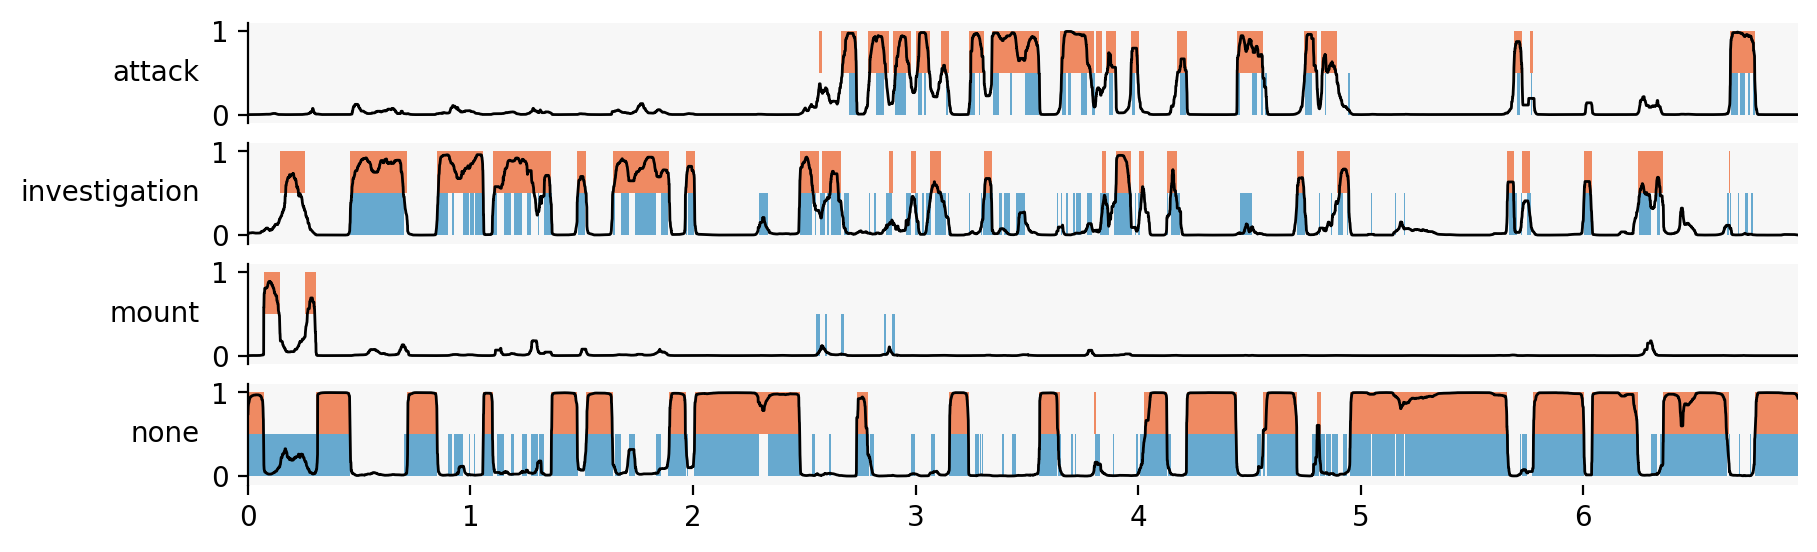

In [13]:
classification_results = k_fold_results[4].classification_results[69].classification_results[('resident', 'intruder')]

plot_classification_timeline(
    classification_results.predictions,
    classification_results.categories,
    annotations=classification_results.annotations,
    timestamps=classification_results.timestamps,
    interval=(-np.inf, np.inf),
    # y_proba=classification_results.y_proba,
    y_proba_smoothed=classification_results.y_proba_smoothed,
    x_tick_step=(60 * 30),
    x_tick_conversion=lambda ticks: [int(tick / (30 * 60)) for tick in ticks],
)

In [19]:
from sklearn.metrics import f1_score

scores = {}

default_decision = 3

for k_fold_result in tqdm(k_fold_results):
    categories = k_fold_result.categories
    y_true_numeric = k_fold_result.y_true_numeric
    y_proba = k_fold_result.y_proba_smoothed
    probability = y_proba.max(axis=1)

    for label in range(len(categories)):
        if label == default_decision:
            continue
        if label not in scores:
            scores[label] = []
        scores[label].append([])
        for threshold in np.linspace(0, 1, 101, endpoint=True):
            decision = np.argmax(y_proba, axis=1)
            decision[(decision == label) & (probability < threshold)] = default_decision
            scores[label][-1].append(f1_score(y_true_numeric == label, decision == label, zero_division=np.nan))
        scores[label][-1] = np.asarray(scores[label][-1])

for label in scores:
    scores[label] = np.asarray(scores[label])

  0%|          | 0/5 [00:00<?, ?it/s]

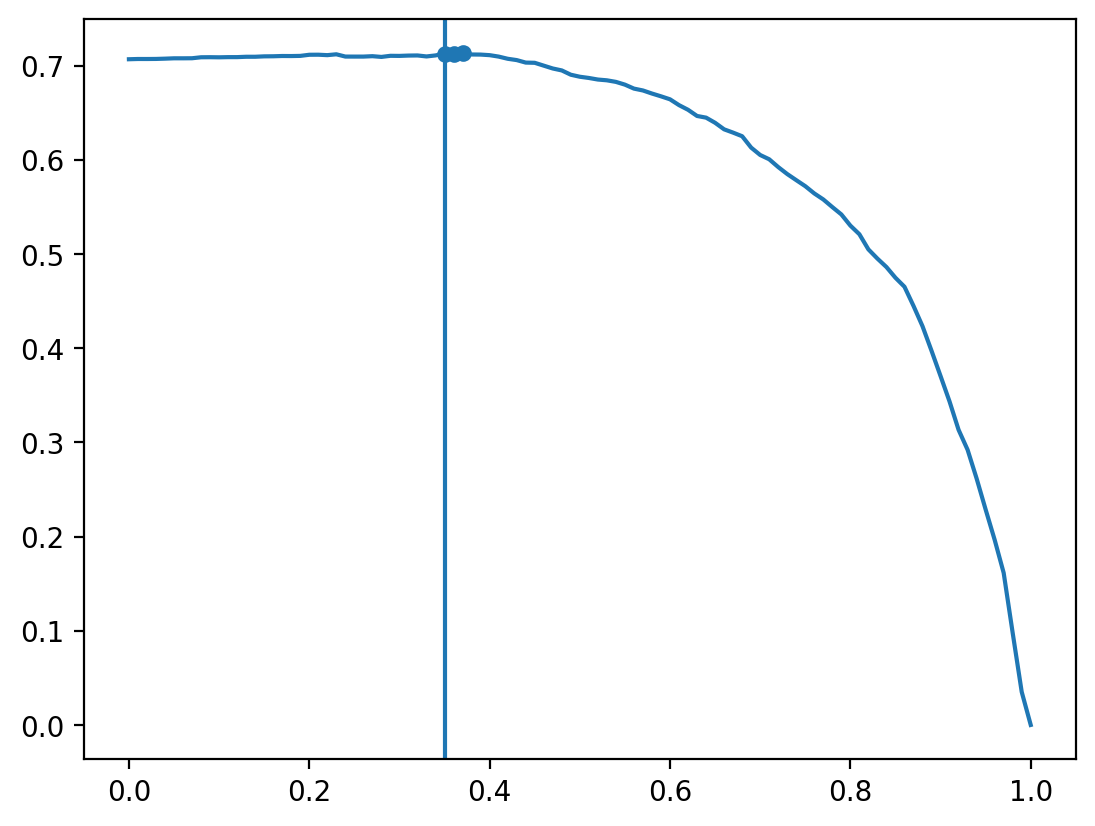

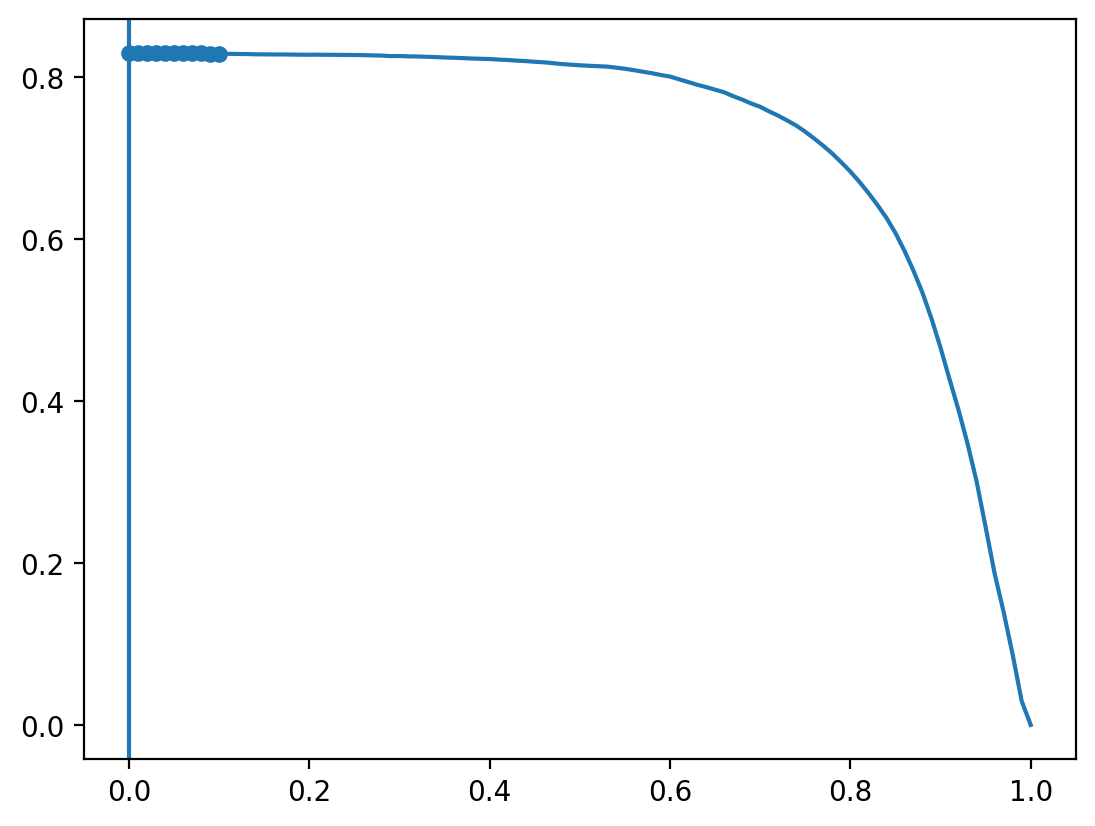

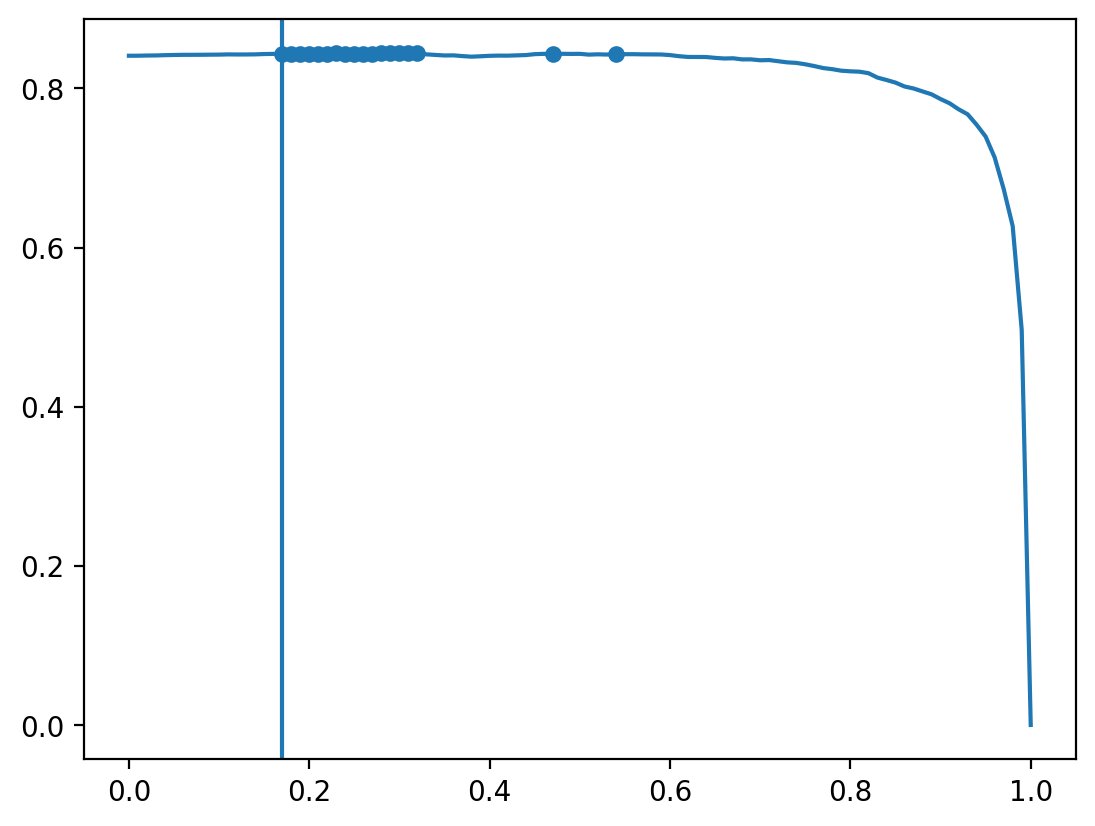

In [20]:
for label in scores:
    tolerance = 0.001

    avg_score = scores[label].mean(axis=0)
    best = np.argwhere(avg_score >= avg_score.max() - tolerance).ravel()

    plt.plot(np.linspace(0, 1, 101, endpoint=True), avg_score)
    plt.scatter(np.linspace(0, 1, 101, endpoint=True)[best], avg_score[best], lw=0)
    plt.axvline(np.linspace(0, 1, 101, endpoint=True)[best[0]])

    plt.show()

In [ ]:
from sklearn.metrics import f1_score

f1_score(
    dataset_train.encode(dataset_classification_result.predictions["true_category"].to_numpy()),
    dataset_train.encode(dataset_classification_result.predictions["category"].to_numpy()),
    labels=range(len(dataset_train.categories)),
    average=None,
)

In [ ]:
from sklearn.metrics import f1_score

f1_score(
    dataset_train.encode(dataset_classification_result.predictions["true_category"].to_numpy()),
    dataset_train.encode(dataset_classification_result.predictions["category"].to_numpy()),
    labels=range(len(dataset_train.categories)),
    average=None,
)

In [ ]:
from sklearn.metrics import f1_score

f1_score(
    dataset_train.encode(dataset_classification_result.predictions["true_category"].to_numpy()),
    dataset_train.encode(dataset_classification_result.predictions["category"].to_numpy()),
    labels=range(len(dataset_train.categories)),
    average=None,
)

In [ ]:
from classification_utils import validate_predictions, interval_f1_score

import matplotlib.pyplot as plt

plt.boxplot(
    [
        f1_scores[np.isfinite(f1_scores)]
        for f1_scores in
        interval_f1_score(
            dataset_classification_result.predictions,
            dataset_classification_result.annotations,
            encode_func=dataset_train.encode,
            num_categories=len(dataset_train.categories),
        ).T
    ]
)
plt.show()

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
y_test_numeric = dataset_train.encode(y_test)
y_pred = xgbc.predict(X_test)

plot_confusion_matrix(y_test_numeric, y_pred, category_labels=["att", "inv", "mnt", "none"])

In [ ]:
f1_score(y_test_numeric, y_pred, average=None)

In [ ]:
dataset_predictions_test = to_prediction_dataset(classification_result_dataset_test, target="dyads")

In [ ]:
save_dataset(dataset_predictions_test, directory="datasets", dataset_name="mice_predictions", annotation_type="predictions")

In [ ]:
from automated_scoring.io import load_dataset

dataset_predictions = load_dataset(directory="datasets", target="dyads", categories=('attack', 'investigation', 'mount', 'none'), dataset_name="mice_predictions", annotation_type="predictions")

In [ ]:
from observation_library import ObservationLibrary
from glob import glob
import json

annotations = dataset_predictions.get_annotations(exclude=[("intruder", "resident")])

video_files = sorted(glob("/home/paul/Downloads/task1_videos_mp4/test/*.mp4"))
video_lookup = {idx: [video_file] for idx, video_file in enumerate(video_files)}
trajectory_lookup = {
    group: dataset_predictions.select(group).trajectories
    for group in (
        dataset_predictions.groups
        if isinstance(dataset_predictions.groups, dict)
        else range(len(dataset_predictions.groups))
    )
}

observation_library = ObservationLibrary(
    annotations,
    video_lookup=video_lookup,
    trajectory_lookup=trajectory_lookup,
    num_keypoints=7,
    filter_dependencies={
        "actor": ("group", ),
        "recipient": ("group", "actor"),
    },
    highlight_observations_mode="category",
    selected_observations_mode="dyad",
)

with open("render_settings.json", "r") as f:
    render_settings = json.load(f)
    for key in render_settings:
        setattr(observation_library.render_settings, key, render_settings[key])

observation_library